In [11]:
# AMES Mutagenicity Prediction Model
# Outreachy Contribution for Ersilia Open Source Initiative

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import os
import sys
import joblib
from flaml import AutoML

# Set random seed for reproducibility
np.random.seed(42)

# Create directories for outputs if they don't exist
os.makedirs("../figures", exist_ok=True)
os.makedirs("../models", exist_ok=True)

sys.path.append(os.path.abspath(".."))

## Data Loading and Initial Exploration

In [12]:
# Load the featurized AMES datasets
train_data = pd.read_csv('../data/AMES_train_featurized.csv')
valid_data = pd.read_csv('../data/AMES_valid_featurized.csv')
test_data = pd.read_csv('../data/AMES_test_featurized.csv')

# Display basic information about the datasets
print("Training dataset shape:", train_data.shape)
print("Validation dataset shape:", valid_data.shape)
print("Testing dataset shape:", test_data.shape)

# Display first few rows of the training data
print("\nFirst few rows of training data:")
print(train_data.head())

# Check for missing values in each dataset
print("\nMissing values in training data:")
print(train_data.isnull().sum().sum())
print("\nMissing values in validation data:")
print(valid_data.isnull().sum().sum())
print("\nMissing values in test data:")
print(test_data.isnull().sum().sum())

Training dataset shape: (5115, 14)
Validation dataset shape: (732, 14)
Testing dataset shape: (1461, 14)

First few rows of training data:
  Drug_ID                                               Drug    Y  sa-score  \
0  Drug 1       O=[N+]([O-])c1c2c(c3ccc4cccc5ccc1c3c45)CCCC2  1.0  2.503751   
1  Drug 2  O=c1c2ccccc2c(=O)c2c1ccc1c2[nH]c2c3c(=O)c4cccc...  0.0  2.917230   
2  Drug 3                          [N-]=[N+]=CC(=O)NCC(=O)NN  1.0  3.460701   
3  Drug 3                          [N-]=[N+]=CC(=O)NCC(=O)NN  1.0  3.460701   
4  Drug 4                          [N-]=[N+]=C1C=NC(=O)NC1=O  1.0  4.191218   

   molecular-weight     pca_1     pca_2     pca_3     pca_4    umap_1  \
0           301.345  0.899294 -0.143518  0.215578  0.291642 -0.076072   
1           646.614  0.876555 -0.044332  0.115856 -0.088108 -0.274776   
2           157.133  0.925751  0.278572  0.166847  0.382162  0.396931   
3           157.133  0.925751  0.278572  0.166847  0.382162  0.396931   
4           138.086  

### Data Preprocessing

In [13]:
# Function to preprocess each dataset
def preprocess_data(data):
    # Remove duplicates if any
    data = data.drop_duplicates(subset=["Drug"]).reset_index(drop=True)

    # Convert string representations of lists to numeric values
    def extract_numeric_from_list_str(value):
        if isinstance(value, str) and value.startswith("[") and value.endswith("]"):
            # Extract the number from the list string
            return float(value.strip("[]"))
        return value

    # Apply to molecular-weight column
    data["molecular-weight"] = data["molecular-weight"].apply(
        extract_numeric_from_list_str
    )

    # Drop rows with NaN values in the target variable
    data = data.dropna(subset=["Y"]).reset_index(drop=True)

    return data


# Preprocess each dataset
print("\nPreprocessing data...")
train_data = preprocess_data(train_data)
valid_data = preprocess_data(valid_data)
test_data = preprocess_data(test_data)

# Prepare features and target for each dataset
X_train = train_data.drop(["Drug_ID", "Drug", "Y"], axis=1)
y_train = train_data["Y"]

X_valid = valid_data.drop(["Drug_ID", "Drug", "Y"], axis=1)
y_valid = valid_data["Y"]

X_test = test_data.drop(["Drug_ID", "Drug", "Y"], axis=1)
y_test = test_data["Y"]

# Check if there are any NaN values in the target variables
print("\nAny NaN values in y_train after cleaning:", y_train.isna().any())
print("Any NaN values in y_valid after cleaning:", y_valid.isna().any())
print("Any NaN values in y_test after cleaning:", y_test.isna().any())

# Standardize the features
print("\nStandardizing features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

print("\nTraining set shape:", X_train.shape)
print("Validation set shape:", X_valid.shape)
print("Testing set shape:", X_test.shape)

train_data


Preprocessing data...

Any NaN values in y_train after cleaning: False
Any NaN values in y_valid after cleaning: False
Any NaN values in y_test after cleaning: False

Standardizing features...

Training set shape: (5084, 11)
Validation set shape: (726, 11)
Testing set shape: (1454, 11)


,Drug_ID,Drug,Y,sa-score,molecular-weight,pca_1,pca_2,pca_3,pca_4,umap_1,umap_2,tsne_1,tsne_2,RA_score
0,Drug 1,O=[N+]([O-])c1c2c(c3ccc4cccc5ccc1c3c45)CCCC2,1.0,2.503751,301.345,0.899294,-0.143518,0.215578,0.291642,-0.076072,0.539872,-0.147871,0.003480,0.589678
1,Drug 2,O=c1c2ccccc2c(=O)c2c1ccc1c2[nH]c2c3c(=O)c4cccc...,0.0,2.917230,646.614,0.876555,-0.044332,0.115856,-0.088108,-0.274776,0.575504,-0.285146,0.134448,0.117515
2,Drug 3,[N-]=[N+]=CC(=O)NCC(=O)NN,1.0,3.460701,157.133,0.925751,0.278572,0.166847,0.382162,0.396931,-0.256953,0.368721,0.499495,0.990367
3,Drug 4,[N-]=[N+]=C1C=NC(=O)NC1=O,1.0,4.191218,138.086,0.907137,0.168471,0.168094,0.322551,0.724734,-0.101986,0.189056,0.468957,0.865731
4,Drug 6,CCCCN(CC(O)C1=CC(=[N+]=[N-])C(=O)C=C1)N=O,1.0,4.367447,264.285,0.918652,0.064792,0.151348,0.334007,0.372053,-0.065391,0.147324,0.283283,0.593191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5079,Drug 7568,CCC(CCC(C)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C)C(C)C,0.0,4.388040,444.575,0.919389,-0.134667,0.054714,0.257788,-0.662964,0.283070,-0.584093,-0.587950,0.832119
5080,Drug 7587,CCCCCCCCCCCCOCCO,0.0,1.832039,414.718,0.950282,-0.180538,-0.475202,0.530847,-0.495139,-0.133025,0.996910,0.114508,0.990506
5081,Drug 7593,CCOP(=S)(CC)Sc1ccccc1,0.0,3.325132,230.392,0.929781,0.094909,-0.002934,0.586086,0.545920,0.320847,0.693856,-0.242151,0.925968
5082,Drug 7598,C=C(C)C1CC=C(C)C(OC(C)=O)C1,0.0,3.591624,246.337,0.928272,0.269280,0.058985,0.321101,0.442530,-0.298871,0.487381,0.302440,0.655075


### Exploratory Data Analysis


Performing exploratory data analysis...


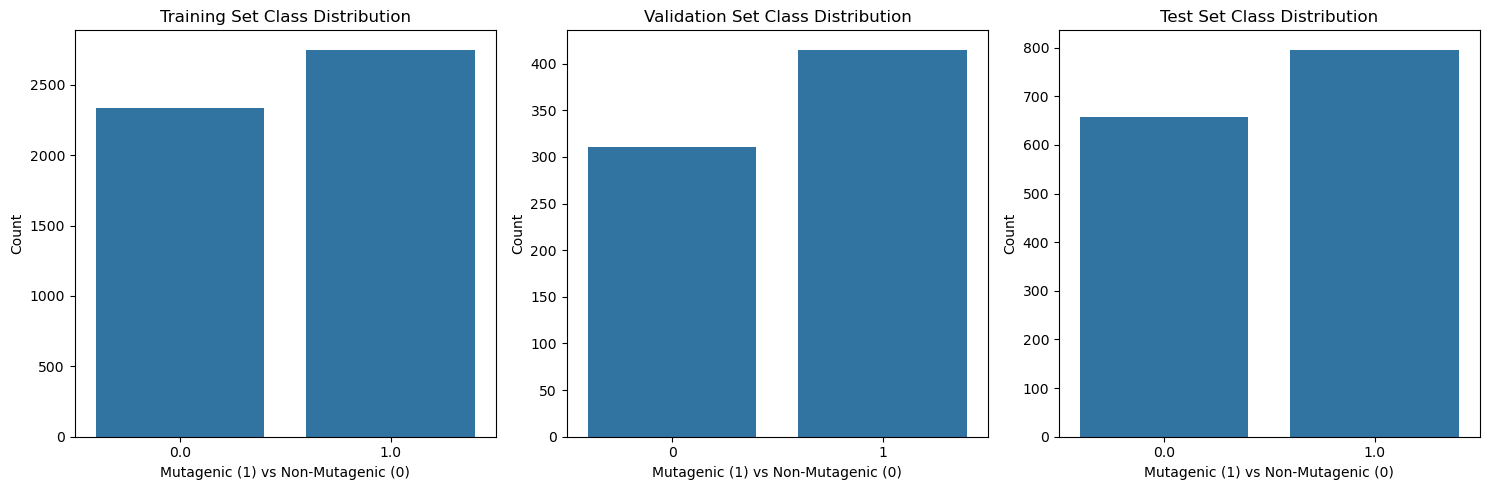

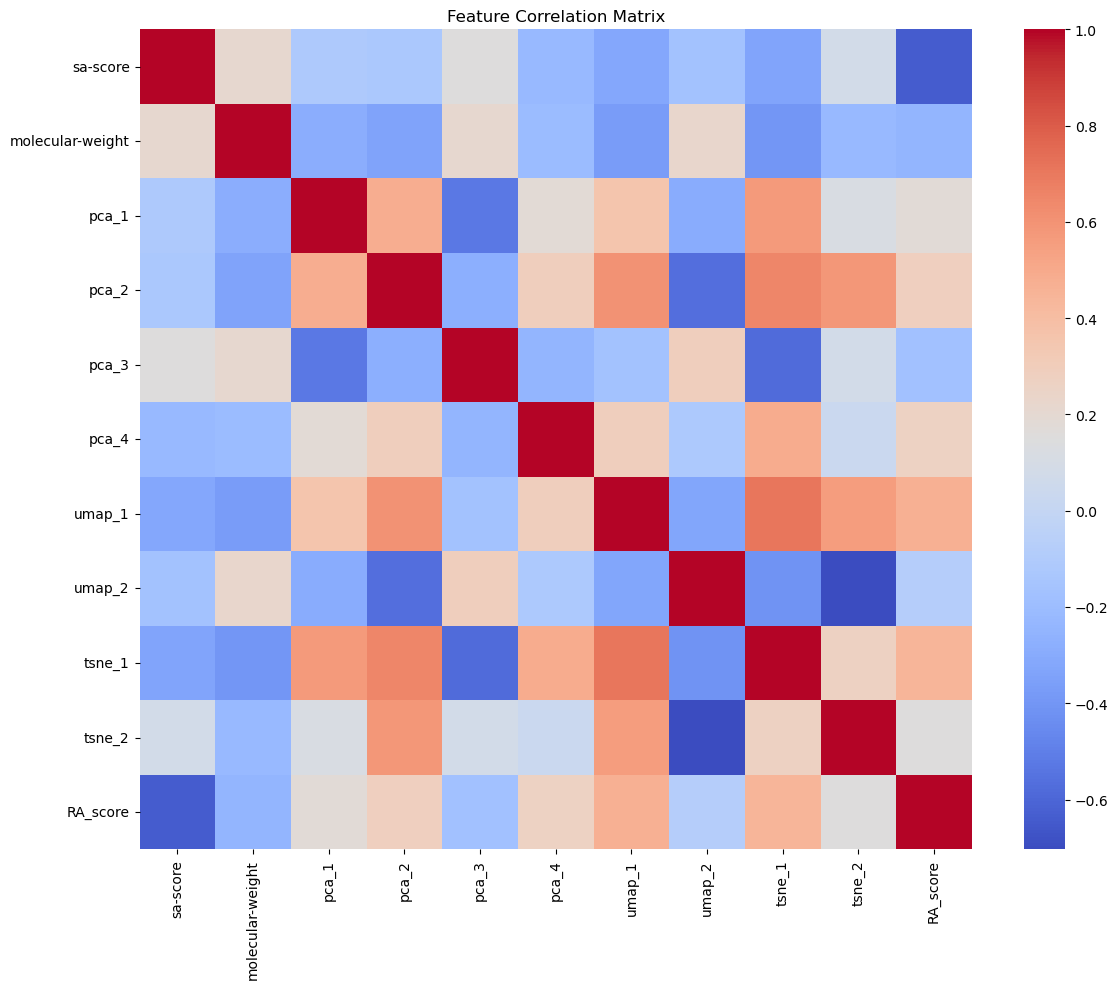

In [14]:
print("\nPerforming exploratory data analysis...")

# Visualize the class distribution in each dataset
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.countplot(x=y_train)
plt.title("Training Set Class Distribution")
plt.xlabel("Mutagenic (1) vs Non-Mutagenic (0)")
plt.ylabel("Count")

plt.subplot(1, 3, 2)
sns.countplot(x=y_valid)
plt.title("Validation Set Class Distribution")
plt.xlabel("Mutagenic (1) vs Non-Mutagenic (0)")
plt.ylabel("Count")

plt.subplot(1, 3, 3)
sns.countplot(x=y_test)
plt.title("Test Set Class Distribution")
plt.xlabel("Mutagenic (1) vs Non-Mutagenic (0)")
plt.ylabel("Count")

plt.tight_layout()
plt.savefig("../figures/class_distribution.png")
plt.show()

# Feature correlations
plt.figure(figsize=(12, 10))
correlation_matrix = X_train.corr()
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.savefig("../figures/feature_correlations.png")
plt.show()

### Model Training and Evaluation 


Training Random Forest model...

Random Forest Results on Validation Set:
Accuracy: 0.7575757575757576

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.74      0.72       311
           1       0.80      0.77      0.78       415

    accuracy                           0.76       726
   macro avg       0.75      0.75      0.75       726
weighted avg       0.76      0.76      0.76       726


Random Forest Results on Test Set:
Accuracy: 0.7420907840440165

Classification Report:
              precision    recall  f1-score   support

         0.0       0.73      0.68      0.71       658
         1.0       0.75      0.79      0.77       796

    accuracy                           0.74      1454
   macro avg       0.74      0.74      0.74      1454
weighted avg       0.74      0.74      0.74      1454



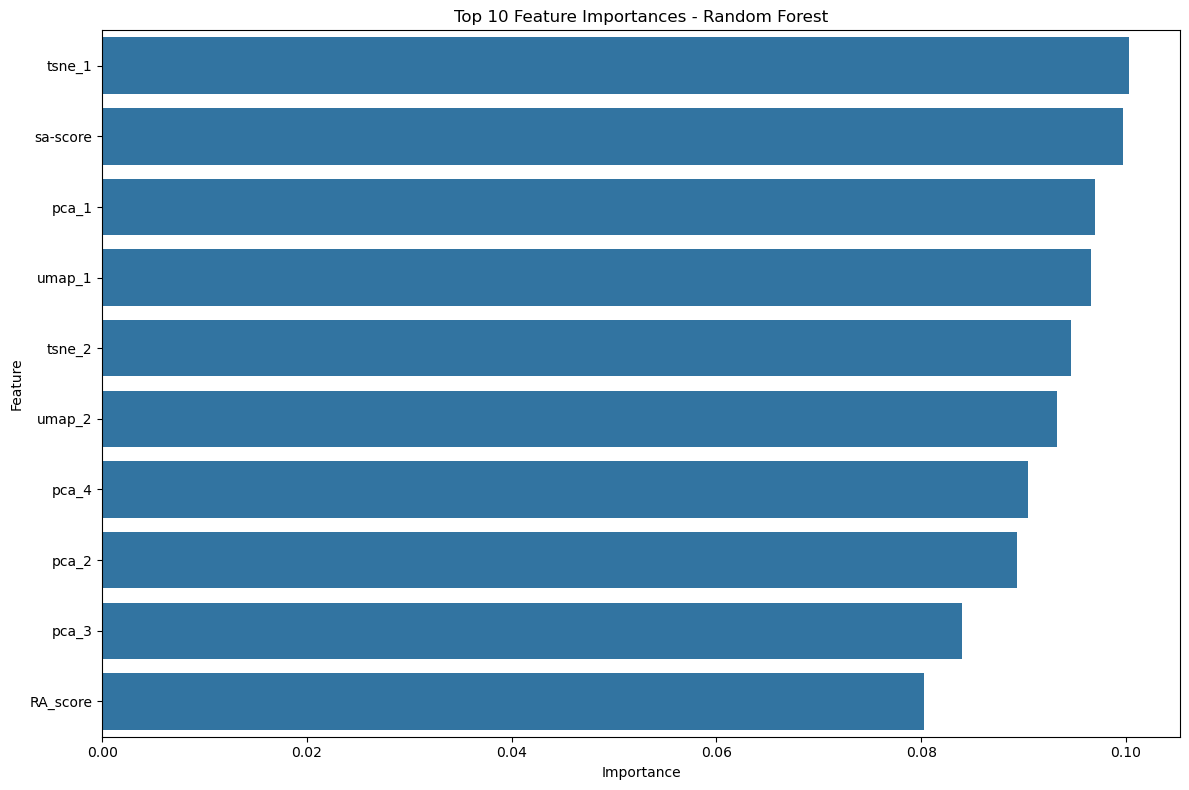


Top 5 most important features for Random Forest:
1. tsne_1: 0.1003
2. sa-score: 0.0997
3. pca_1: 0.0970
4. umap_1: 0.0966
5. tsne_2: 0.0946

Training XGBoost model...

XGBoost Results on Validation Set:
Accuracy: 0.7079889807162535

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.67      0.66       311
           1       0.75      0.74      0.74       415

    accuracy                           0.71       726
   macro avg       0.70      0.70      0.70       726
weighted avg       0.71      0.71      0.71       726


XGBoost Results on Test Set:
Accuracy: 0.7269601100412655

Classification Report:
              precision    recall  f1-score   support

         0.0       0.71      0.67      0.69       658
         1.0       0.74      0.78      0.76       796

    accuracy                           0.73      1454
   macro avg       0.72      0.72      0.72      1454
weighted avg       0.73      0.73      0.73      1454



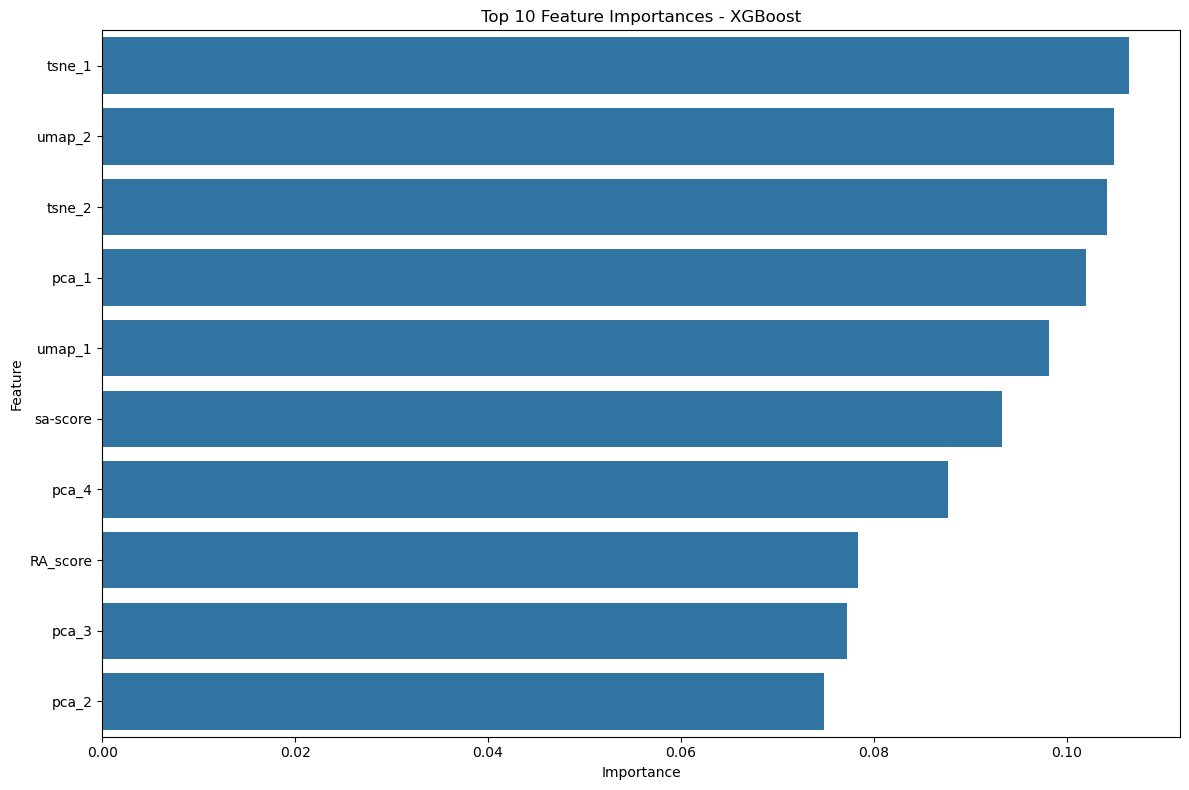


Top 5 most important features for XGBoost:
1. tsne_1: 0.1064
2. umap_2: 0.1049
3. tsne_2: 0.1041
4. pca_1: 0.1020
5. umap_1: 0.0981

Training FLAML AutoML model...
[flaml.automl.logger: 04-07 16:27:23] {1728} INFO - task = classification
[flaml.automl.logger: 04-07 16:27:23] {1739} INFO - Evaluation method: cv
[flaml.automl.logger: 04-07 16:27:23] {1838} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 04-07 16:27:23] {1955} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd', 'lrl1']
[flaml.automl.logger: 04-07 16:27:23] {2258} INFO - iteration 0, current learner lgbm


/home/nyagah/miniconda3/envs/ersilia/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/nyagah/miniconda3/envs/ersilia/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/nyagah/miniconda3/envs/ersilia/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/nyagah/miniconda3/envs/ersilia/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 04-07 16:27:24] {2393} INFO - Estimated sufficient time budget=15422s. Estimated necessary time budget=357s.
[flaml.automl.logger: 04-07 16:27:24] {2442} INFO -  at 1.6s,	estimator lgbm's best error=0.4101,	best estimator lgbm's best error=0.4101
[flaml.automl.logger: 04-07 16:27:24] {2258} INFO - iteration 1, current learner lgbm


/home/nyagah/miniconda3/envs/ersilia/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/nyagah/miniconda3/envs/ersilia/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/nyagah/miniconda3/envs/ersilia/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 04-07 16:27:25] {2442} INFO -  at 1.8s,	estimator lgbm's best error=0.4101,	best estimator lgbm's best error=0.4101
[flaml.automl.logger: 04-07 16:27:25] {2258} INFO - iteration 2, current learner lgbm
[flaml.automl.logger: 04-07 16:27:25] {2442} INFO -  at 2.0s,	estimator lgbm's best error=0.3851,	best estimator lgbm's best error=0.3851
[flaml.automl.logger: 04-07 16:27:25] {2258} INFO - iteration 3, current learner lgbm


/home/nyagah/miniconda3/envs/ersilia/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/nyagah/miniconda3/envs/ersilia/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/nyagah/miniconda3/envs/ersilia/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/nyagah/miniconda3/envs/ersilia/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/nyagah/miniconda3/envs/ersilia/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid f

[flaml.automl.logger: 04-07 16:27:25] {2442} INFO -  at 2.3s,	estimator lgbm's best error=0.3460,	best estimator lgbm's best error=0.3460
[flaml.automl.logger: 04-07 16:27:25] {2258} INFO - iteration 4, current learner lgbm


/home/nyagah/miniconda3/envs/ersilia/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/nyagah/miniconda3/envs/ersilia/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/nyagah/miniconda3/envs/ersilia/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/nyagah/miniconda3/envs/ersilia/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/nyagah/miniconda3/envs/ersilia/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid f

[flaml.automl.logger: 04-07 16:27:25] {2442} INFO -  at 2.5s,	estimator lgbm's best error=0.3460,	best estimator lgbm's best error=0.3460
[flaml.automl.logger: 04-07 16:27:25] {2258} INFO - iteration 5, current learner lgbm


/home/nyagah/miniconda3/envs/ersilia/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/nyagah/miniconda3/envs/ersilia/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/nyagah/miniconda3/envs/ersilia/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/nyagah/miniconda3/envs/ersilia/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 04-07 16:27:25] {2442} INFO -  at 2.7s,	estimator lgbm's best error=0.3460,	best estimator lgbm's best error=0.3460
[flaml.automl.logger: 04-07 16:27:25] {2258} INFO - iteration 6, current learner lgbm


/home/nyagah/miniconda3/envs/ersilia/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/nyagah/miniconda3/envs/ersilia/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/nyagah/miniconda3/envs/ersilia/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/nyagah/miniconda3/envs/ersilia/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/nyagah/miniconda3/envs/ersilia/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid f

[flaml.automl.logger: 04-07 16:27:26] {2442} INFO -  at 3.1s,	estimator lgbm's best error=0.3460,	best estimator lgbm's best error=0.3460
[flaml.automl.logger: 04-07 16:27:26] {2258} INFO - iteration 7, current learner lgbm


/home/nyagah/miniconda3/envs/ersilia/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/nyagah/miniconda3/envs/ersilia/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/nyagah/miniconda3/envs/ersilia/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/nyagah/miniconda3/envs/ersilia/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/nyagah/miniconda3/envs/ersilia/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid f

[flaml.automl.logger: 04-07 16:27:26] {2442} INFO -  at 3.3s,	estimator lgbm's best error=0.3460,	best estimator lgbm's best error=0.3460
[flaml.automl.logger: 04-07 16:27:26] {2258} INFO - iteration 8, current learner lgbm


/home/nyagah/miniconda3/envs/ersilia/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/nyagah/miniconda3/envs/ersilia/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/nyagah/miniconda3/envs/ersilia/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 04-07 16:27:26] {2442} INFO -  at 3.7s,	estimator lgbm's best error=0.3399,	best estimator lgbm's best error=0.3399
[flaml.automl.logger: 04-07 16:27:26] {2258} INFO - iteration 9, current learner lgbm


/home/nyagah/miniconda3/envs/ersilia/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/nyagah/miniconda3/envs/ersilia/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/nyagah/miniconda3/envs/ersilia/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/nyagah/miniconda3/envs/ersilia/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 04-07 16:27:27] {2442} INFO -  at 4.0s,	estimator lgbm's best error=0.3399,	best estimator lgbm's best error=0.3399
[flaml.automl.logger: 04-07 16:27:27] {2258} INFO - iteration 10, current learner lgbm


/home/nyagah/miniconda3/envs/ersilia/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/nyagah/miniconda3/envs/ersilia/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/nyagah/miniconda3/envs/ersilia/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/nyagah/miniconda3/envs/ersilia/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/nyagah/miniconda3/envs/ersilia/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid f

[flaml.automl.logger: 04-07 16:27:29] {2442} INFO -  at 6.4s,	estimator lgbm's best error=0.3043,	best estimator lgbm's best error=0.3043
[flaml.automl.logger: 04-07 16:27:29] {2258} INFO - iteration 11, current learner sgd
Error running FLAML AutoML: Input X contains NaN.
Normalizer does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values
Skipping FLAML AutoML evaluation.


/home/nyagah/miniconda3/envs/ersilia/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [15]:
print("\nTraining Random Forest model...")
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train_scaled, y_train)

# Evaluate on validation set
y_pred_rf_valid = rf_model.predict(X_valid_scaled)
print("\nRandom Forest Results on Validation Set:")
print("Accuracy:", accuracy_score(y_valid, y_pred_rf_valid))
print("\nClassification Report:")
print(classification_report(y_valid, y_pred_rf_valid))

# Evaluate on test set
y_pred_rf_test = rf_model.predict(X_test_scaled)
print("\nRandom Forest Results on Test Set:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf_test))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf_test))

# Feature importance
plt.figure(figsize=(12, 8))
feature_importance = pd.DataFrame(
    {"Feature": X_train.columns, "Importance": rf_model.feature_importances_}
).sort_values(by="Importance", ascending=False)
sns.barplot(x="Importance", y="Feature", data=feature_importance.head(10))
plt.title("Top 10 Feature Importances - Random Forest")
plt.tight_layout()
plt.savefig("../figures/rf_feature_importance.png")
plt.show()

# Print top 5 features
print("\nTop 5 most important features for Random Forest:")
for i, (feature, importance) in enumerate(
    zip(feature_importance["Feature"].head(5), feature_importance["Importance"].head(5))
):
    print(f"{i+1}. {feature}: {importance:.4f}")

# 4.2 XGBoost Classifier
print("\nTraining XGBoost model...")
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# Evaluate on validation set
y_pred_xgb_valid = xgb_model.predict(X_valid_scaled)
print("\nXGBoost Results on Validation Set:")
print("Accuracy:", accuracy_score(y_valid, y_pred_xgb_valid))
print("\nClassification Report:")
print(classification_report(y_valid, y_pred_xgb_valid))

# Evaluate on test set
y_pred_xgb_test = xgb_model.predict(X_test_scaled)
print("\nXGBoost Results on Test Set:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb_test))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb_test))

# Feature importance
plt.figure(figsize=(12, 8))
feature_importance_xgb = pd.DataFrame(
    {"Feature": X_train.columns, "Importance": xgb_model.feature_importances_}
).sort_values(by="Importance", ascending=False)
sns.barplot(x="Importance", y="Feature", data=feature_importance_xgb.head(10))
plt.title("Top 10 Feature Importances - XGBoost")
plt.tight_layout()
plt.savefig("../figures/xgb_feature_importance.png")
plt.show()

# Print top 5 features
print("\nTop 5 most important features for XGBoost:")
for i, (feature, importance) in enumerate(
    zip(
        feature_importance_xgb["Feature"].head(5),
        feature_importance_xgb["Importance"].head(5),
    )
):
    print(f"{i+1}. {feature}: {importance:.4f}")

# 4.3 FLAML AutoML (if time permits)
try:
    print("\nTraining FLAML AutoML model...")
    automl = AutoML()
    settings = {
        "time_budget": 300,  # 5 minutes
        "metric": "accuracy",
        "task": "classification",
    }

    automl.fit(X_train_scaled, y_train, **settings)

    # Evaluate on validation set
    y_pred_automl_valid = automl.predict(X_valid_scaled)
    print("\nFLAML AutoML Results on Validation Set:")
    print("Best ML model:", automl.best_estimator)
    print("Accuracy:", accuracy_score(y_valid, y_pred_automl_valid))
    print("\nClassification Report:")
    print(classification_report(y_valid, y_pred_automl_valid))

    # Evaluate on test set
    y_pred_automl_test = automl.predict(X_test_scaled)
    print("\nFLAML AutoML Results on Test Set:")
    print("Accuracy:", accuracy_score(y_test, y_pred_automl_test))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_automl_test))
except Exception as e:
    print(f"Error running FLAML AutoML: {e}")
    print("Skipping FLAML AutoML evaluation.")

### Hyperparameter Tuning

In [16]:
print("\nPerforming hyperparameter tuning for Random Forest...")
from sklearn.model_selection import GridSearchCV

# Define a smaller parameter grid for demonstration
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    scoring="accuracy",
    verbose=1,
)

grid_search.fit(X_train_scaled, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Evaluate the tuned model
best_rf_model = grid_search.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_test_scaled)

print("\nTuned Random Forest Results on Test Set:")
print("Accuracy:", accuracy_score(y_test, y_pred_best_rf))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best_rf))


Performing hyperparameter tuning for Random Forest...
Fitting 3 folds for each of 12 candidates, totalling 36 fits


Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation score: 0.7191190145333347

Tuned Random Forest Results on Test Set:
Accuracy: 0.7420907840440165

Classification Report:
              precision    recall  f1-score   support

         0.0       0.73      0.68      0.71       658
         1.0       0.75      0.79      0.77       796

    accuracy                           0.74      1454
   macro avg       0.74      0.74      0.74      1454
weighted avg       0.74      0.74      0.74      1454



### Model improvement with SMOTE

In [17]:
from scripts.add_smote import apply_smote, plot_class_distribution

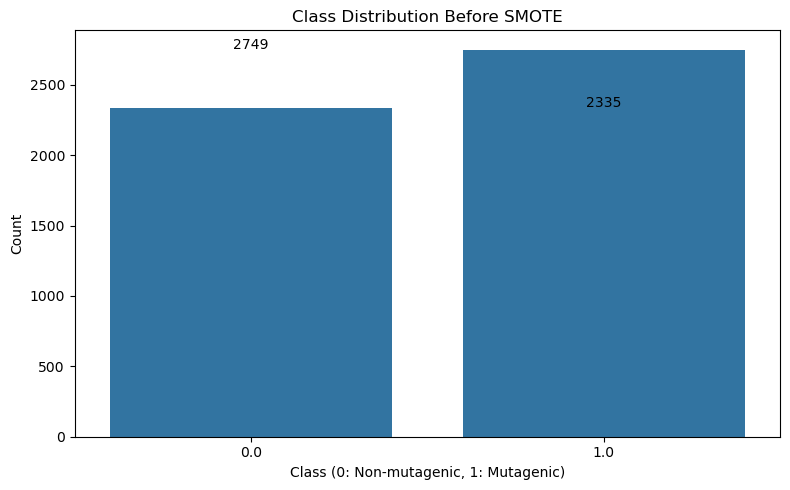

Found 1 NaN values in the data. Handling missing values...
Missing values have been imputed with mean values.
Original class distribution:
Counter({1.0: 2749, 0.0: 2335})

Class distribution after SMOTE:
Counter({1.0: 2749, 0.0: 2749})


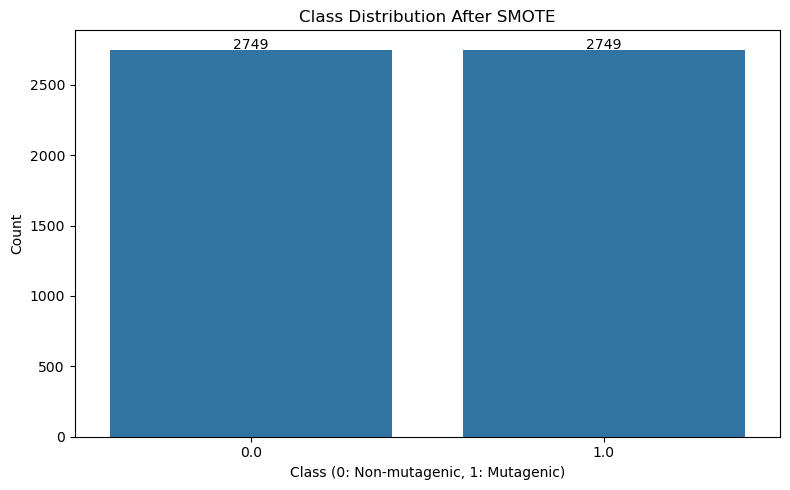


Training Random Forest with SMOTE-resampled data...

Random Forest with SMOTE Results on Validation Set:
Accuracy: 0.7341597796143251

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.75      0.71       311
           1       0.79      0.72      0.76       415

    accuracy                           0.73       726
   macro avg       0.73      0.74      0.73       726
weighted avg       0.74      0.73      0.74       726


Random Forest with SMOTE Results on Test Set:
Accuracy: 0.7310866574965612

Classification Report:
              precision    recall  f1-score   support

         0.0       0.70      0.71      0.70       658
         1.0       0.76      0.75      0.75       796

    accuracy                           0.73      1454
   macro avg       0.73      0.73      0.73      1454
weighted avg       0.73      0.73      0.73      1454


Training XGBoost with SMOTE-resampled data...

XGBoost with SMOTE Results on Validatio

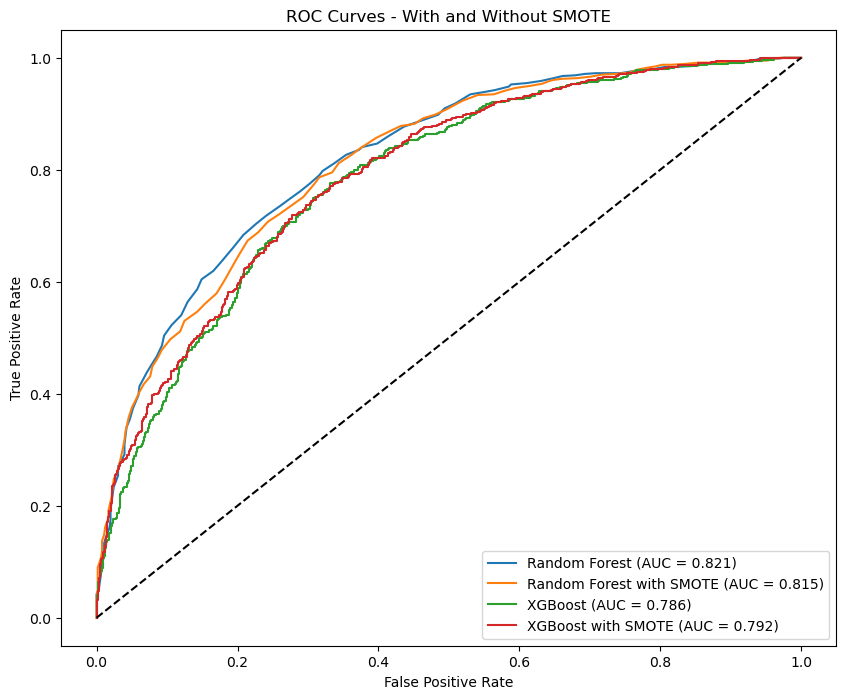

In [18]:
# Visualize class distribution before SMOTE
plt_before = plot_class_distribution(y_train, "Class Distribution Before SMOTE")
plt_before.savefig("../figures/class_distribution_before_smote.png")
plt_before.show()

# Apply SMOTE to balance the training data
X_train_smote, y_train_smote = apply_smote(X_train_scaled, y_train)

# Visualize class distribution after SMOTE
plt_after = plot_class_distribution(y_train_smote, "Class Distribution After SMOTE")
plt_after.savefig("../figures/class_distribution_after_smote.png")
plt_after.show()

# Train models with SMOTE-resampled data
print("\nTraining Random Forest with SMOTE-resampled data...")
rf_model_smote = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model_smote.fit(X_train_smote, y_train_smote)

# Evaluate on validation set
y_pred_rf_valid_smote = rf_model_smote.predict(X_valid_scaled)
print("\nRandom Forest with SMOTE Results on Validation Set:")
print("Accuracy:", accuracy_score(y_valid, y_pred_rf_valid_smote))
print("\nClassification Report:")
print(classification_report(y_valid, y_pred_rf_valid_smote))

# Evaluate on test set
y_pred_rf_test_smote = rf_model_smote.predict(X_test_scaled)
print("\nRandom Forest with SMOTE Results on Test Set:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf_test_smote))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf_test_smote))

# Train XGBoost with SMOTE-resampled data
print("\nTraining XGBoost with SMOTE-resampled data...")
xgb_model_smote = xgb.XGBClassifier(random_state=42)
xgb_model_smote.fit(X_train_smote, y_train_smote)

# Evaluate on validation set
y_pred_xgb_valid_smote = xgb_model_smote.predict(X_valid_scaled)
print("\nXGBoost with SMOTE Results on Validation Set:")
print("Accuracy:", accuracy_score(y_valid, y_pred_xgb_valid_smote))
print("\nClassification Report:")
print(classification_report(y_valid, y_pred_xgb_valid_smote))

# Evaluate on test set
y_pred_xgb_test_smote = xgb_model_smote.predict(X_test_scaled)
print("\nXGBoost with SMOTE Results on Test Set:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb_test_smote))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb_test_smote))

# Compare ROC curves with and without SMOTE
plt.figure(figsize=(10, 8))

# Original Random Forest
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.3f})")

# SMOTE Random Forest
y_pred_proba_rf_smote = rf_model_smote.predict_proba(X_test_scaled)[:, 1]
fpr_rf_smote, tpr_rf_smote, _ = roc_curve(y_test, y_pred_proba_rf_smote)
roc_auc_rf_smote = auc(fpr_rf_smote, tpr_rf_smote)
plt.plot(
    fpr_rf_smote,
    tpr_rf_smote,
    label=f"Random Forest with SMOTE (AUC = {roc_auc_rf_smote:.3f})",
)

# Original XGBoost
y_pred_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {roc_auc_xgb:.3f})")

# SMOTE XGBoost
y_pred_proba_xgb_smote = xgb_model_smote.predict_proba(X_test_scaled)[:, 1]
fpr_xgb_smote, tpr_xgb_smote, _ = roc_curve(y_test, y_pred_proba_xgb_smote)
roc_auc_xgb_smote = auc(fpr_xgb_smote, tpr_xgb_smote)
plt.plot(
    fpr_xgb_smote,
    tpr_xgb_smote,
    label=f"XGBoost with SMOTE (AUC = {roc_auc_xgb_smote:.3f})",
)

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - With and Without SMOTE")
plt.legend(loc="lower right")
plt.savefig("../figures/roc_curves_with_smote.png")
plt.show()

### Final Model Selection and Saving

In [19]:
# Determine the best model based on validation accuracy
rf_valid_acc = accuracy_score(y_valid, y_pred_rf_valid)
xgb_valid_acc = accuracy_score(y_valid, y_pred_xgb_valid)
tuned_rf_valid_acc = accuracy_score(y_valid, best_rf_model.predict(X_valid_scaled))
rf_smote_valid_acc = accuracy_score(y_valid, y_pred_rf_valid_smote)
xgb_smote_valid_acc = accuracy_score(y_valid, y_pred_xgb_valid_smote)

try:
    automl_valid_acc = accuracy_score(y_valid, y_pred_automl_valid)
    accuracies = {
        "Random Forest": rf_valid_acc,
        "XGBoost": xgb_valid_acc,
        "Tuned Random Forest": tuned_rf_valid_acc,
        "Random Forest with SMOTE": rf_smote_valid_acc,
        "XGBoost with SMOTE": xgb_smote_valid_acc,
        "FLAML AutoML": automl_valid_acc,
    }
except:
    accuracies = {
        "Random Forest": rf_valid_acc,
        "XGBoost": xgb_valid_acc,
        "Tuned Random Forest": tuned_rf_valid_acc,
        "Random Forest with SMOTE": rf_smote_valid_acc,
        "XGBoost with SMOTE": xgb_smote_valid_acc,
    }

best_model_name = max(accuracies, key=accuracies.get)
print(
    f"\nBest model based on validation accuracy: {best_model_name} with accuracy {accuracies[best_model_name]:.4f}"
)

# Print a comparison of all models
print("\nModel Comparison (Validation Accuracy):")
for model_name, acc in sorted(accuracies.items(), key=lambda x: x[1], reverse=True):
    print(f"{model_name}: {acc:.4f}")

# Save the best model
if best_model_name == "Random Forest":
    best_model = rf_model
    joblib.dump(rf_model, "../models/best_model_rf.pkl")
    print("Random Forest model saved as '../models/best_model_rf.pkl'")
elif best_model_name == "XGBoost":
    best_model = xgb_model
    joblib.dump(xgb_model, "../models/best_model_xgb.pkl")
    print("XGBoost model saved as '../models/best_model_xgb.pkl'")
elif best_model_name == "Tuned Random Forest":
    best_model = best_rf_model
    joblib.dump(best_rf_model, "../models/best_model_tuned_rf.pkl")
    print("Tuned Random Forest model saved as '../models/best_model_tuned_rf.pkl'")
elif best_model_name == "Random Forest with SMOTE":
    best_model = rf_model_smote
    joblib.dump(rf_model_smote, "../models/best_model_rf_smote.pkl")
    print("Random Forest with SMOTE model saved as '../models/best_model_rf_smote.pkl'")
elif best_model_name == "XGBoost with SMOTE":
    best_model = xgb_model_smote
    joblib.dump(xgb_model_smote, "../models/best_model_xgb_smote.pkl")
    print("XGBoost with SMOTE model saved as '../models/best_model_xgb_smote.pkl'")
elif best_model_name == "FLAML AutoML":
    best_model = automl
    joblib.dump(automl, "../models/best_model_automl.pkl")
    print("FLAML AutoML model saved as '../models/best_model_automl.pkl'")

# Save the scaler for future use
joblib.dump(scaler, "../models/feature_scaler.pkl")
print("Feature scaler saved as '../models/feature_scaler.pkl'")

# Create a comprehensive model evaluation summary
print("\nComprehensive Evaluation of Best Model:")
if best_model_name in ["Random Forest with SMOTE", "XGBoost with SMOTE"]:
    print("This model was trained with SMOTE to address class imbalance.")

# Test set metrics for the best model
if best_model_name == "Random Forest":
    y_pred_test = y_pred_rf_test
elif best_model_name == "XGBoost":
    y_pred_test = y_pred_xgb_test
elif best_model_name == "Tuned Random Forest":
    y_pred_test = best_rf_model.predict(X_test_scaled)
elif best_model_name == "Random Forest with SMOTE":
    y_pred_test = y_pred_rf_test_smote
elif best_model_name == "XGBoost with SMOTE":
    y_pred_test = y_pred_xgb_test_smote
elif best_model_name == "FLAML AutoML":
    y_pred_test = y_pred_automl_test

# Calculate and print test metrics
test_accuracy = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)

print(f"\nTest Set Performance Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")

# Create a DataFrame to save the results
results_df = pd.DataFrame(
    {
        "Model": [best_model_name],
        "Validation_Accuracy": [accuracies[best_model_name]],
        "Test_Accuracy": [test_accuracy],
        "Test_Precision": [test_precision],
        "Test_Recall": [test_recall],
        "Test_F1": [test_f1],
        "Date": [pd.Timestamp.now().strftime("%Y-%m-%d")],
    }
)

# Save the results
os.makedirs("../results", exist_ok=True)
results_df.to_csv("../results/model_performance_summary.csv", index=False)
print("\nResults saved to '../results/model_performance_summary.csv'")


Best model based on validation accuracy: Random Forest with accuracy 0.7576

Model Comparison (Validation Accuracy):
Random Forest: 0.7576
Tuned Random Forest: 0.7576
Random Forest with SMOTE: 0.7342
XGBoost: 0.7080
XGBoost with SMOTE: 0.6901
Random Forest model saved as '../models/best_model_rf.pkl'
Feature scaler saved as '../models/feature_scaler.pkl'

Comprehensive Evaluation of Best Model:

Test Set Performance Metrics:
Accuracy: 0.7421
Precision: 0.7515
Recall: 0.7902
F1 Score: 0.7704

Results saved to '../results/model_performance_summary.csv'


### Example Predictions

In [20]:
# Demonstrate the model on a few examples
print("\nDemonstrating predictions on example compounds...")
example_indices = [0, 10, 20, 30, 40]  # Choose some diverse examples
examples = test_data.iloc[example_indices].reset_index(drop=True)

# Prepare features
X_examples = examples.drop(["Drug_ID", "Drug", "Y"], axis=1)
X_examples_scaled = scaler.transform(X_examples)

# Make predictions with the best model
predictions = best_model.predict(X_examples_scaled)
probabilities = best_model.predict_proba(X_examples_scaled)[:, 1]

# Create a results dataframe
results = pd.DataFrame(
    {
        "SMILES": examples["Drug"],
        "Actual": examples["Y"],
        "Predicted": predictions,
        "Probability": probabilities,
    }
)

print("\nExample Predictions:")
for i, row in results.iterrows():
    print(f"\nCompound {i+1}:")
    print(f"SMILES: {row['SMILES']}")
    print(f"Actual class: {'Mutagenic' if row['Actual'] == 1.0 else 'Non-mutagenic'}")
    print(
        f"Predicted class: {'Mutagenic' if row['Predicted'] == 1.0 else 'Non-mutagenic'}"
    )
    print(f"Probability of being mutagenic: {row['Probability']:.4f}")

print("\nModel training and evaluation complete!")


Demonstrating predictions on example compounds...

Example Predictions:

Compound 1:
SMILES: Cc1cc(=O)oc2ccc3c(c12)C1(C)OOC1(C)O3
Actual class: Mutagenic
Predicted class: Mutagenic
Probability of being mutagenic: 0.8500

Compound 2:
SMILES: COc1nsc2cccc([N+](=O)[O-])c12
Actual class: Mutagenic
Predicted class: Mutagenic
Probability of being mutagenic: 0.7300

Compound 3:
SMILES: CC(C)N(N)C(C)C
Actual class: Mutagenic
Predicted class: Non-mutagenic
Probability of being mutagenic: 0.3300

Compound 4:
SMILES: O=C1NC(=O)[C@@H]2CC=CC[C@H]12
Actual class: Non-mutagenic
Predicted class: Non-mutagenic
Probability of being mutagenic: 0.3700

Compound 5:
SMILES: Cc1c2ccccc2c(CO)c2ccccc12
Actual class: Mutagenic
Predicted class: Mutagenic
Probability of being mutagenic: 0.8200

Model training and evaluation complete!
